In [1]:
from rs_graph.data import (
    load_extended_paper_details_dataset,
    load_basic_repos_dataset,
)
import numpy as np

np.random.seed(42)

repos = load_basic_repos_dataset()
papers = load_extended_paper_details_dataset().sample(1000)

# Get repo name from repos dataset and merge with papers on doi
papers = papers.merge(repos[["repo", "doi"]], on="doi")

# Format into ready for training
papers = papers.drop(columns=["url", "authors", "citation_count"])

# Drop duplicates
papers = papers.drop_duplicates(subset=["doi"])
papers["source"] = "rs-graph"
papers.sample(3)

,corpus_id,doi,title,abstract,tldr,topics,primary_topic,secondary_topic,repo,source
269,235499615,10.21105/joss.02878,Isoreader: An R package to read stable isotope...,The measurement and interpretation of the stab...,The isoreader package implements an easily ext...,"[Computer Science, Environmental Science, Chem...",Computer Science,Environmental Science,https://github.com/isoverse/isoreader,rs-graph
604,216652479,10.21105/joss.02145,Visions: An Open-Source Library for Semantic Data,Many common data workflows such as loading tab...,Many common data workflows such as loading tab...,[Computer Science],Computer Science,None,https://github.com/dylan-profiler/visions,rs-graph
633,255169724,10.21105/joss.05034,daiquiri: Data Quality Reporting for Temporal ...,The daiquiri R package generates data quality ...,None,"[Computer Science, Medicine]",Computer Science,Medicine,https://github.com/ropensci/daiquiri,rs-graph


In [2]:
import pandas as pd
from rs_graph.data.enrichment.semantic_scholar import get_extended_paper_details

# Load truede dataset
truede = pd.read_csv("truede-data.csv")

# Only keep papers which are "referencing" a paper
truede = truede[truede["Referencing or not"] == "yes"]

# Only keep papers which have a relationship of "official"
truede = truede[truede["RQ2 Relationship between Repository and Paper"] == "official"]

# Format to basics
truede = truede.rename(
    columns={
        "Link to GitHub Repository": "repo",
        "Link to paper": "paper_url",
    }
)[["repo", "paper_url"]]

# Get extended paper details
truede["paper_url"] = truede.paper_url.apply(lambda x: f"url:{x}")
truede_paper_details = get_extended_paper_details(
    truede.paper_url.tolist(),
    filter_out_nones=False,
)

# Attach paper details to truede as columns
truede_rows_with_paper_details = []
for repo, paper_detail in zip(truede.repo, truede_paper_details, strict=True):
    if paper_detail is not None:
        truede_rows_with_paper_details.append(
            {
                "corpus_id": paper_detail.corpus_id,
                "doi": paper_detail.doi,
                "title": paper_detail.title,
                "abstract": paper_detail.abstract,
                "repo": repo,
                "tldr": paper_detail.tldr,
                "primary_topic": paper_detail.primary_topic,
                "secondary_topic": paper_detail.secondary_topic,
            }
        )

# Convert to dataframe
extended_truede_details = pd.DataFrame(truede_rows_with_paper_details)

# Keep track of source
extended_truede_details["source"] = "truede"
extended_truede_details.sample(3)

  0%|          | 0/136 [00:00<?, ?it/s]

,corpus_id,doi,title,abstract,repo,tldr,primary_topic,secondary_topic,source
1,53022775,url:https://arxiv.org/abs/1810.10551,Fast and accurate object detection in high res...,Machine learning has celebrated a lot of achie...,https://github.com/previtus/AttentionPipeline,An attention pipeline method which uses two st...,Computer Science,Engineering,truede
37,13666009,url:https://www.aclweb.org/anthology/L18-1507.pdf,A Workbench for Rapid Generation of Cross-Ling...,The need for cross-lingual information access ...,https://github.com/nisargjhaveri/news-access,"This work describes a flexible, web-based tool...",Computer Science,Linguistics,truede
59,19525135,url:https://arxiv.org/abs/1711.10604,TensorFlow Distributions,The TensorFlow Distributions library implement...,https://github.com/tensorflow/probability,The TensorFlow Distributions library implement...,Computer Science,Mathematics,truede


In [3]:
# Process the "findresearch.org" dataset
from pathlib import Path
import xml.etree.ElementTree as ET
from parse import parse

# Keep track of the doi and the repo link (if it points at github.com)
findresearch_doi_and_repo = []

# Iter over all xml files
conf_dir = Path(
    "~/Downloads/findresearchdata/conferences/conf/"
).expanduser().resolve(strict=True)
for conf_xml_file in conf_dir.glob("**/*.xml"):
    # Read the file
    try:
        tree = ET.parse(conf_xml_file)
    except Exception:
        continue

    # Get the root
    root = tree.getroot()

    # Iter over "article" element in the top level "conference" element
    for article in root.findall("article"):
        # Get the verified tag for possible subsetting later
        verified = article.attrib.get("verified", None)

        # Get the badge tag for possible subsetting later
        badge = article.attrib.get("badge", None)

        # Get the DOI URL
        doi_url = article.find("url")
        if doi_url is None:
            continue
            
        # Get the DOI
        if "doi.org" not in doi_url.text:
            continue
        
        # Get and format the DOI
        doi = doi_url.text.replace("https://doi.org/", "")

        # Next get the all of the artifacts from the "artifacts" element
        artifacts = article.find("artifacts")
        if artifacts is None:
            continue

        # Then get the sub element "urlArtifacts"
        url_artifacts = artifacts.find("urlArtifacts")
        if url_artifacts is None:
            continue

        # Get the artifacts
        for url_artifact in url_artifacts.findall("artifact"):
            repo_url = None
            # If "github.com" in the artifact text then we have a repo
            if "github.com" in url_artifact.text:
                repo_url = url_artifact.text

            if "github.io" in url_artifact.text:
                github_parts = parse(
                    "https://{owner}.github.io/{repo}",
                    url_artifact.text,
                )
                if github_parts is not None:
                    owner = github_parts["owner"]
                    repo = github_parts["repo"].replace("/", "")  # may have trailing
                    repo_url = f"https://github.com/{owner}/{repo}"
            
            # Append new row
            if repo_url is not None:
                findresearch_doi_and_repo.append(
                    {
                        "doi": doi,
                        "repo": repo_url,
                        "verified": verified,
                        "badge": badge,
                    }
                )

# Convert to dataframe
findresearch_doi_and_repo = pd.DataFrame(findresearch_doi_and_repo)
findresearch_doi_and_repo

,doi,repo,verified,badge
0,10.1145/2896377.2901458,https://github.com/eliavb/all_distance_sketch,false,false
1,10.1145/2896377.2901453,https://github.com/CMU-SAFARI,false,false
2,10.1145/3078505.3078523,https://github.com/ngast/meanFieldAccuracy,false,false
3,10.1109/ICDE.2017.243,https://github.com/Crystal-SDS,false,false
4,10.1109/ICDE.2017.243,https://github.com/apache/phoenix/tree/master/...,false,false
...,...,...,...,...
2054,10.1109/FG.2017.105,https://github.com/TadasBaltrusaitis/OpenFace/...,false,false
2055,10.1109/FG.2017.83,https://github.com/sgrasshof/tensor_facemodel,false,false
2056,10.1109/FG.2017.82,https://github.com/playerkk/face-py-faster-rcnn,true,false
2057,10.1109/FG.2015.7284869,https://github.com/TadasBaltrusaitis/FERA-2015,true,false


In [4]:
# Get extended paper details
findresearch_doi_and_repo["doi"] = findresearch_doi_and_repo.doi.apply(
    lambda x: f"doi:{x}",
)
findresearch_doi_and_repo_paper_details = get_extended_paper_details(
    findresearch_doi_and_repo.doi.tolist(),
    filter_out_nones=False,
)

# Attach paper details to truede as columns
findresearch_rows_with_paper_details = []
for repo, paper_detail in zip(
    findresearch_doi_and_repo.repo,
    findresearch_doi_and_repo_paper_details,
    strict=True,
):
    if paper_detail is not None:
        findresearch_rows_with_paper_details.append(
            {
                "corpus_id": paper_detail.corpus_id,
                "doi": paper_detail.doi,
                "title": paper_detail.title,
                "abstract": paper_detail.abstract,
                "repo": repo,
                "tldr": paper_detail.tldr,
                "primary_topic": paper_detail.primary_topic,
                "secondary_topic": paper_detail.secondary_topic,
            }
        )

# Convert to dataframe
extended_findresesearch_details = pd.DataFrame(findresearch_rows_with_paper_details)

# Keep track of source
extended_findresesearch_details["source"] = "findresearch.org"
extended_findresesearch_details.sample(3)

  0%|          | 0/2059 [00:00<?, ?it/s]

,corpus_id,doi,title,abstract,repo,tldr,primary_topic,secondary_topic,source
159,7411487,doi:10.1145/2851141.2851153,Declarative coordination of graph-based parall...,Declarative programming has been hailed as a p...,http://github.com/flavioc/meld,"CLM is introduced, a concurrent forward-chaini...",Computer Science,None,findresearch.org
952,16145504,doi:10.1145/2809695.2817865,Demo: PolyPoint: High-Precision Indoor Localiz...,"We demonstrate PolyPoint, a high-fidelity RF-b...",https://github.com/lab11/polypoint,"PolyPoint introduces an efficient, novel rangi...",Computer Science,Engineering,findresearch.org
1329,17091315,doi:10.1145/2976749.2978372,Hypnoguard: Protecting Secrets across Sleep-wa...,Attackers can get physical control of a comput...,https://github.com/iSECPartners/yontma,"To the best of the knowledge, Hypnoguard provi...",Computer Science,None,findresearch.org


In [5]:
# Merge with papers
papers = pd.concat(
    [papers, extended_truede_details, extended_findresesearch_details],
    ignore_index=True,
)
papers = papers.reset_index(drop=True)

# Drop duplicate repos
papers = papers.drop_duplicates(subset=["repo"])

papers.source.value_counts()

findresearch.org    1923
rs-graph             997
truede                77
Name: source, dtype: int64

In [6]:
# Create a column for "singular_topic" which is preferred to be "secondary_topic"
# but if that is None then use "primary_topic"
papers["singular_topic"] = papers.secondary_topic.combine_first(papers.primary_topic)

# Drop papers without a singular topic
papers = papers.dropna(subset=["singular_topic"])
papers.singular_topic.value_counts()

Computer Science                  1522
Engineering                        542
Mathematics                        253
Physics                            135
Environmental Science              118
Medicine                            92
Biology                             85
Linguistics                         57
Materials Science                   32
Geography                           23
Chemistry                           21
Geology                             20
Psychology                          15
Business                            15
Education                           10
Sociology                           10
Economics                            9
Art                                  8
Law                                  7
Political Science                    7
History                              4
Agricultural and Food Sciences       2
Name: singular_topic, dtype: int64

In [7]:
# for each repo, get the reademe (if it exists) and the description.
from dotenv import load_dotenv
from ghapi.all import GhApi
from rs_graph.data.enrichment.github import get_repo_parts_from_url
import base64

load_dotenv()

api = GhApi()

def get_repo_readme(repo: str) -> str | None:
    repo_parts = get_repo_parts_from_url(repo)
    try:
        b64_encoded_readme = api.repos.get_readme(
                owner=repo_parts.owner,
                repo=repo_parts.repo,
            )["content"]
        
        return base64.b64decode(b64_encoded_readme).decode("utf-8")
    except:
        return None

In [8]:
# Get the READMEs and then then embeddings for each README
from tqdm import tqdm
import time

readmes = []
for repo in tqdm(papers["repo"], total=len(papers)):
    readmes.append(get_repo_readme(repo))
    time.sleep(0.85)

# Attach to papers
papers["readme"] = readmes

# Drop nulls
papers = papers.dropna(subset=["readme"])
papers.shape

100%|██████████| 2987/2987 [55:47<00:00,  1.12s/it] 


(2542, 12)

In [9]:
# Get the embeddings for each README
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")

readme_embeddings = model.encode(papers["readme"].tolist(), show_progress_bar=True)
readme_embeddings.shape

Batches:   0%|          | 0/80 [00:00<?, ?it/s]

(2542, 768)

In [10]:
# Attach back to dataframe
papers["readme_embedding"] = [np.array(vec) for vec in readme_embeddings.tolist()]
papers.sample(3)

,corpus_id,doi,title,abstract,tldr,topics,primary_topic,secondary_topic,repo,source,singular_topic,readme,readme_embedding
2800,3358523,doi:10.1145/3136014.3136026,Structural model subtyping with OCL constraints,"In model-driven engineering (MDE), models abst...",This work revisits the traditional notion of o...,NaN,Computer Science,None,https://github.com/mde-subtyping/web,findresearch.org,Computer Science,# Structural Model Subtyping with OCL Constrai...,"[-0.003293696092441678, 0.062255244702100754, ..."
249,259318367,10.21105/joss.05256,gemlog: Data Conversion for the Open-Source Ge...,Infrasound (low-frequency pressure waves in ai...,None,"[Computer Science, Environmental Science, Phys...",Computer Science,Environmental Science,https://github.com/ajakef/gemlog,rs-graph,Environmental Science,# [Installation](https://github.com/ajakef/gem...,"[0.02852459065616131, 0.05288788303732872, 0.0..."
2298,341879,doi:10.4230/LIPIcs.ECOOP.2015.101,Simple and Effective Type Check Removal throug...,Dynamically typed programming languages such a...,"Lazy basic block versioning is introduced, a s...",NaN,Computer Science,None,https://github.com/higgsjs/Higgs/tree/ecoop2015,findresearch.org,Computer Science,Higgs\n=====\n\n[![Build Status](https://travi...,"[-0.017485879361629486, -0.00989497359842062, ..."


In [11]:
# Get the embeddings for each paper abstract
# or if the abstract is None, use the title
papers["paper_text"] = papers["abstract"].fillna(papers["title"])

# Drop any nulls
papers = papers.dropna(subset=["paper_text"])

# Get the embeddings for each paper abstract
paper_embeddings = model.encode(papers["paper_text"].tolist(), show_progress_bar=True)

# Drop paper_text col
papers = papers.drop(columns=["paper_text"])

# Attach back to dataframe
papers["paper_embedding"] = [np.array(vec) for vec in paper_embeddings.tolist()]

# Save to parquet
papers.to_parquet("compiled-repo-paper-dataset.parquet")

papers.sample(3)

Batches:   0%|          | 0/80 [00:00<?, ?it/s]

,corpus_id,doi,title,abstract,tldr,topics,primary_topic,secondary_topic,repo,source,singular_topic,readme,readme_embedding,paper_embedding
2659,47021558,doi:10.1145/3180155.3180186,A Graph Solver for the Automated Generation of...,Many testing and benchmarking scenarios in sof...,This paper proposes a graph solver framework f...,NaN,Computer Science,Engineering,https://github.com/viatra/VIATRA-Generator,findresearch.org,Engineering,# VIATRA-Generator\n\nFor more information vis...,"[-0.013404514640569687, -0.023267630487680435,...","[-0.009686015546321869, -0.010762122459709644,..."
1656,2407593,doi:10.1145/2588555.2594535,H2RDF+: an efficient data management system fo...,The proliferation of data in RDF format has re...,"This paper presents H2 RDF+, an RDF store that...",NaN,Computer Science,None,https://github.com/npapa/h2rdf,findresearch.org,Computer Science,Distributed Indexing and Querying of Big RDF D...,"[0.039743974804878235, 0.015489984303712845, -...","[0.02516745775938034, 0.028939153999090195, 0...."
405,233313181,10.21105/joss.02743,REGENS: an open source Python package for simu...,REcombinatory Genome ENumeration of Subpopulat...,REGENS is an open source Python package that s...,"[Computer Science, Biology]",Computer Science,Biology,https://github.com/EpistasisLab/regens,rs-graph,Biology,[![DOI](https://joss.theoj.org/papers/10.21105...,"[-0.008457375690340996, 0.01739424653351307, -...","[-0.048035915940999985, 0.02675429731607437, -..."


In [12]:
papers.singular_topic.value_counts()

Computer Science                  1288
Engineering                        440
Mathematics                        225
Physics                            125
Environmental Science              100
Medicine                            84
Biology                             76
Linguistics                         45
Materials Science                   29
Chemistry                           21
Geography                           20
Geology                             18
Psychology                          12
Sociology                           10
Business                             9
Education                            8
Economics                            8
Art                                  7
Law                                  6
Political Science                    6
History                              4
Agricultural and Food Sciences       1
Name: singular_topic, dtype: int64

In [13]:
import pandas as pd

# Mark all current columns as label = match
train_ready = papers.copy(deep=True)
train_ready["label"] = "match"

# Construct negative random samples
negative_samples = []
for _, row in tqdm(train_ready.iterrows(), total=len(train_ready)):
    # this row will be the paper
    # draw three other random rows and use the repo information
    # from them as the negative
    for _ in range(1):
        other_row = train_ready.sample(1).iloc[0]

        # resample if the repo is the same
        while other_row["repo"] == row["repo"]:
            other_row = train_ready.sample(1).iloc[0]
        
        # Append the negative example row
        negative_samples.append(
            {
                "corpus_id": row.corpus_id,
                "doi": row.doi,
                "title": row.title,
                "abstract": row.abstract,
                "paper_embedding": row.paper_embedding,
                "repo": other_row.repo,
                "readme": other_row.readme,
                "readme_embedding": other_row.readme_embedding,
                "singular_topic": "random",
                "source": "random",
                "label": "no_match",
            }
        )

# Construct the negative samples dataframe
negative_samples = pd.DataFrame(negative_samples)

# Combine the two dataframes
train_ready = pd.concat([train_ready, negative_samples])
train_ready.sample(3)

100%|██████████| 2542/2542 [00:00<00:00, 3568.58it/s]


,corpus_id,doi,title,abstract,tldr,topics,primary_topic,secondary_topic,repo,source,singular_topic,readme,readme_embedding,paper_embedding,label
1081,144599,doi:10.1145/3078597.3078617,Towards a More Complete Understanding of SDC P...,With the rate of errors that can silently effe...,NaN,NaN,NaN,NaN,https://github.com/wiki-ai/wikiclass,random,random,# Wikipedia article quality classification\n<b...,"[0.051146987825632095, 0.06354431807994843, -0...","[-0.0031916601583361626, 0.04400654509663582, ...",no_match
223,198270174,10.21105/joss.01435,qtl2pleio: Testing pleiotropy vs. separate QTL...,Summary Modern quantitative trait locus (QTL) ...,NaN,NaN,NaN,NaN,https://github.com/hyperloop-rails/powerstation,random,random,# PowerStation\n\n[Powerstation](https://hyper...,"[-0.020342353731393814, 0.04042113199830055, -...","[-0.061096057295799255, 0.019195372238755226, ...",no_match
1605,15665714,doi:10.1145/2882903.2882962,AT-GIS: Highly Parallel Spatial Query Processi...,"Users in many domains, including urban plannin...","AT-GIS is described, a highly-parallel spatial...",NaN,Computer Science,Engineering,https://github.com/miloyip/rapidjson,findresearch.org,Engineering,![RapidJSON logo](doc/logo/rapidjson.png)\n\n!...,"[0.018458057194948196, 0.002324339235201478, -...","[0.0030592360999435186, 0.06040530279278755, -...",match


In [14]:
train_ready.singular_topic.value_counts()

random                            2542
Computer Science                  1288
Engineering                        440
Mathematics                        225
Physics                            125
Environmental Science              100
Medicine                            84
Biology                             76
Linguistics                         45
Materials Science                   29
Chemistry                           21
Geography                           20
Geology                             18
Psychology                          12
Sociology                           10
Business                             9
Education                            8
Economics                            8
Art                                  7
Law                                  6
Political Science                    6
History                              4
Agricultural and Food Sciences       1
Name: singular_topic, dtype: int64

In [15]:
# Create interaction embeddings and train logistic regression CV
train_ready["interaction_embedding"] = train_ready.apply(
    lambda row: row.paper_embedding * row.readme_embedding,
    axis=1,
)

Precision: 0.9522776572668112
Recall: 0.862475442043222
F1: 0.9051546391752577


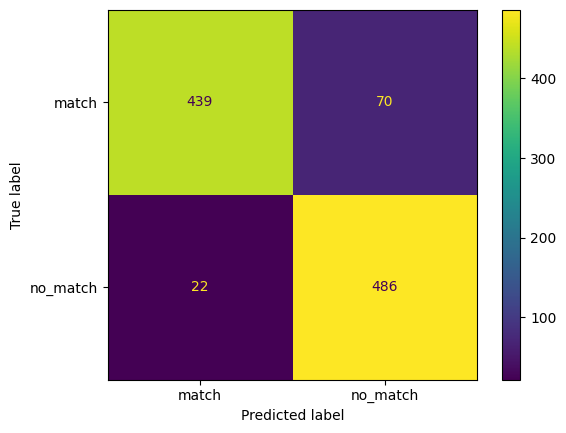

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay

# Split data
train_set, test_set = train_test_split(
    train_ready,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=train_ready["label"].tolist(),
)

# Train model
clf = LogisticRegressionCV(
    cv=10,
    max_iter=1000,
    random_state=42,
    # class_weight="balanced",
).fit(train_set["interaction_embedding"].tolist(), train_set["label"].tolist())

# Evaluate model
y_pred = clf.predict(test_set["interaction_embedding"].tolist())
precision, recall, f1, _ = precision_recall_fscore_support(
    test_set["label"],
    y_pred,
    average="binary",
    pos_label="match",
)

# Print results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(test_set["label"].tolist(), y_pred)

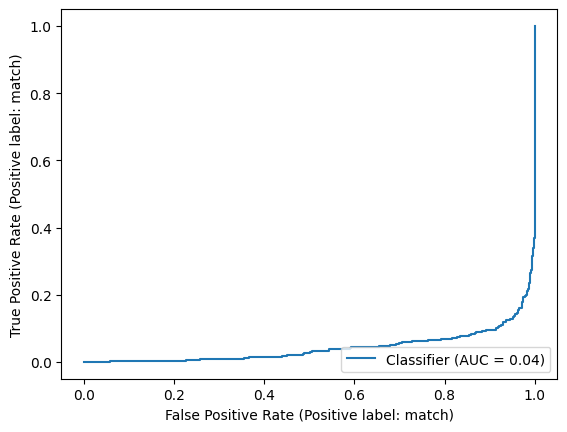

In [17]:
from sklearn.metrics import RocCurveDisplay

y_pred_conf = clf.decision_function(test_set["interaction_embedding"].tolist())
RocCurveDisplay.from_predictions(test_set["label"].tolist(), y_pred_conf, pos_label="match")

/home/eva/miniforge-pypy3/envs/rs-graph/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eva/miniforge-pypy3/envs/rs-graph/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eva/miniforge-pypy3/envs/rs-graph/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


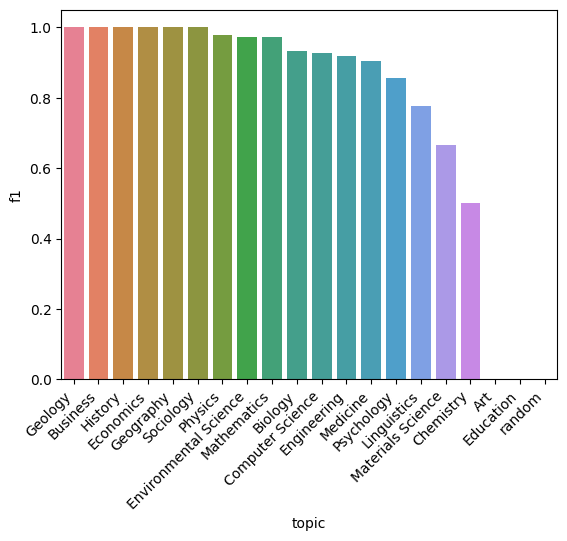

In [18]:
# Calculate metrics on the different singular topics
import seaborn as sns
import matplotlib.pyplot as plt

metrics = []
for topic in test_set.singular_topic.unique():
    topic_df = test_set[test_set.singular_topic == topic]
    y_pred = clf.predict(topic_df["interaction_embedding"].tolist())
    precision, recall, f1, _ = precision_recall_fscore_support(
        topic_df["label"].tolist(),
        y_pred,
        average="binary",
        pos_label="match",
    )
    metrics.append({
        "topic": topic,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    })

metrics = pd.DataFrame(metrics)
metrics = metrics.sort_values(by="f1", ascending=False)

sns.barplot(data=metrics, x="topic", y="f1", hue="topic")
_ = plt.xticks(rotation=45, ha="right")

In [20]:
papers.to_parquet("compiled-repo-paper-dataset.parquet")